# Data Staging - Extract, Transform and Load

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import concurrent.futures
from sqlalchemy import create_engine
from sqlalchemy import text 
import psycopg2

# Extract

In [3]:
df= pd.read_csv('Base.csv')

In [4]:
print(df.dtypes)

fraud_bool                            int64
income                              float64
name_email_similarity               float64
prev_address_months_count             int64
current_address_months_count          int64
customer_age                          int64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                          int64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                  int64
date_of_birth_distinct_emails_4w      int64
employment_status                    object
credit_risk_score                     int64
email_is_free                         int64
housing_status                       object
phone_home_valid                      int64
phone_mobile_valid                    int64
bank_months_count                     int64
has_other_cards                 

# Transform

## Dropping Unrequired Columns 

In [5]:
df = df.drop(["zip_count_4w", "bank_branch_count_8w","date_of_birth_distinct_emails_4w","email_is_free","bank_months_count","month","device_fraud_count"], axis=1) 
print(df.dtypes) 

fraud_bool                        int64
income                          float64
name_email_similarity           float64
prev_address_months_count         int64
current_address_months_count      int64
customer_age                      int64
days_since_request              float64
intended_balcon_amount          float64
payment_type                     object
velocity_6h                     float64
velocity_24h                    float64
velocity_4w                     float64
employment_status                object
credit_risk_score                 int64
housing_status                   object
phone_home_valid                  int64
phone_mobile_valid                int64
has_other_cards                   int64
proposed_credit_limit             int64
foreign_request                   int64
source                           object
session_length_in_minutes       float64
device_os                        object
keep_alive_session                int64
device_distinct_emails_8w         int64


## Handling Outliers 

### Data visualization

Processing column 1/20: fraud_bool


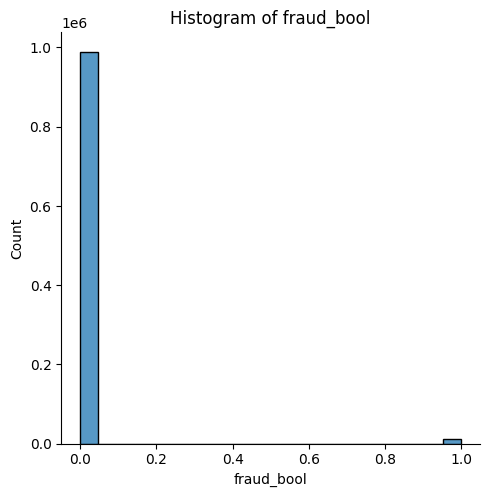

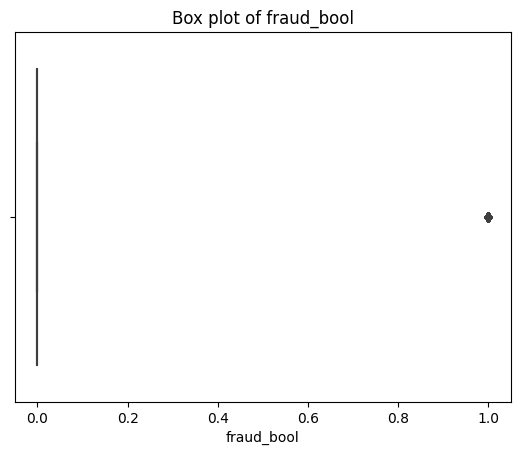

Processing column 2/20: income


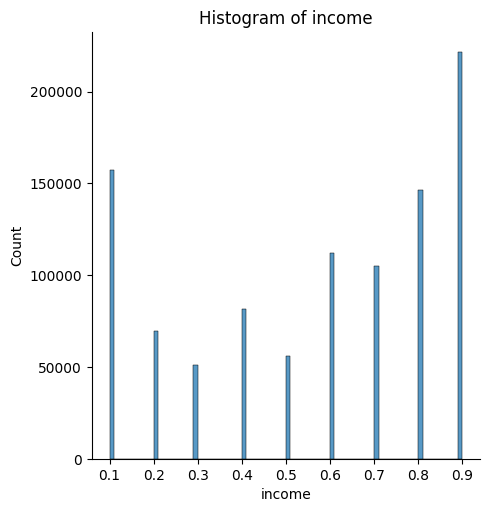

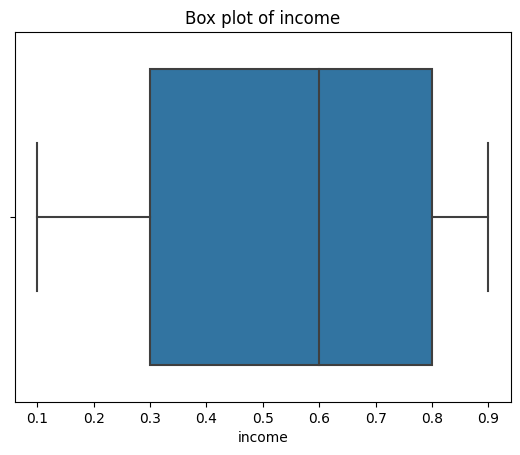

Processing column 3/20: name_email_similarity


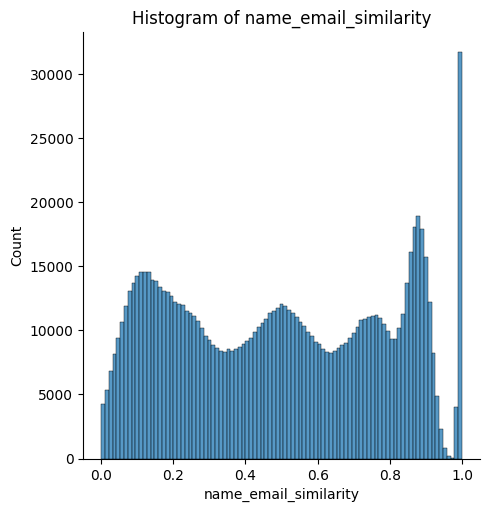

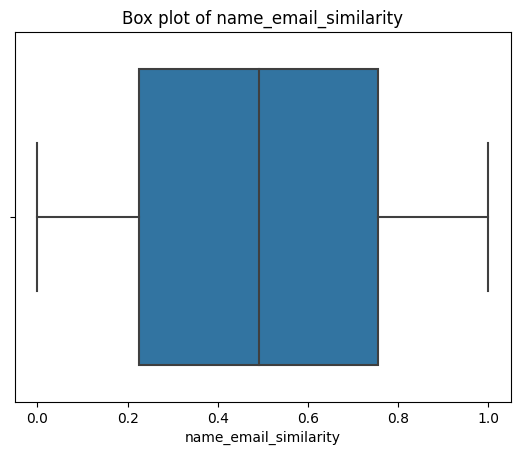

Processing column 4/20: prev_address_months_count


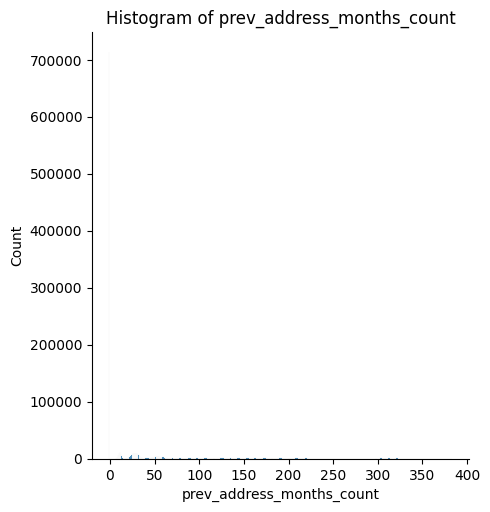

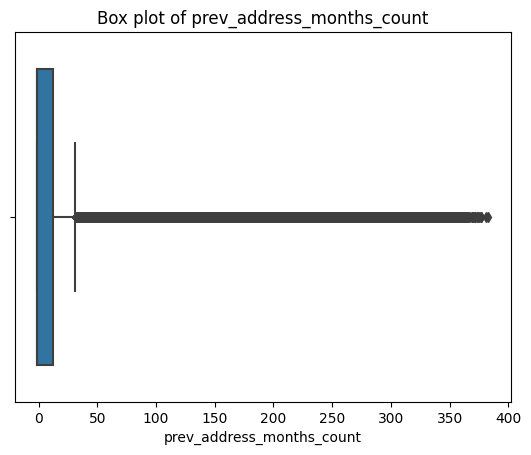

Processing column 5/20: current_address_months_count


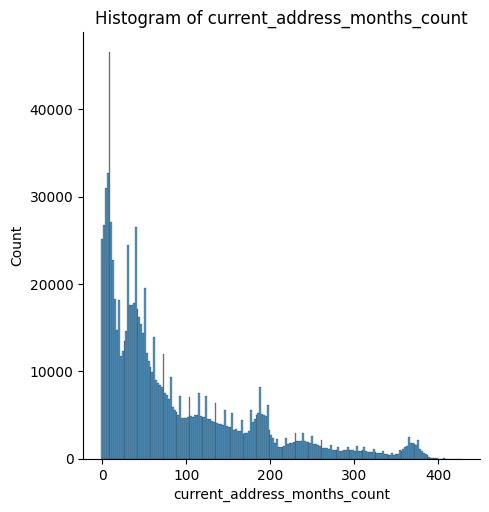

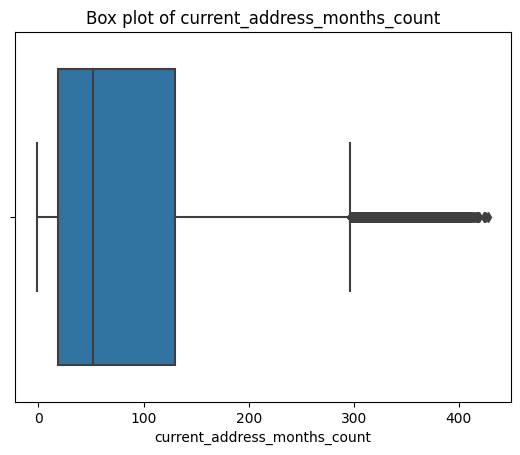

Processing column 6/20: customer_age


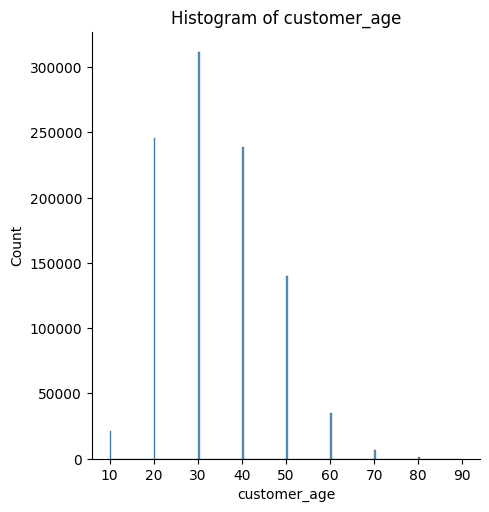

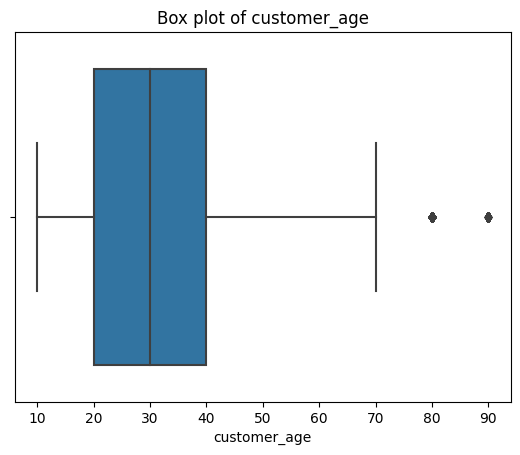

Processing column 8/20: intended_balcon_amount


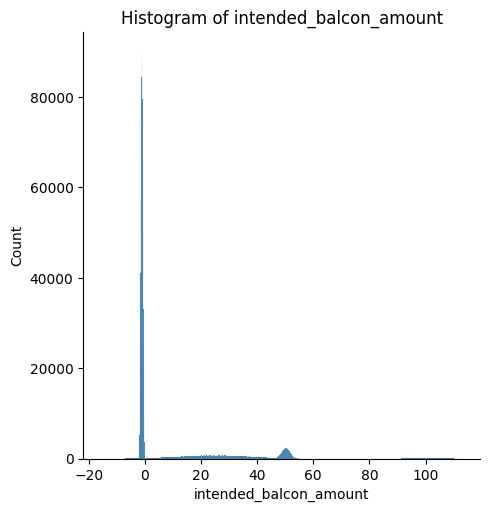

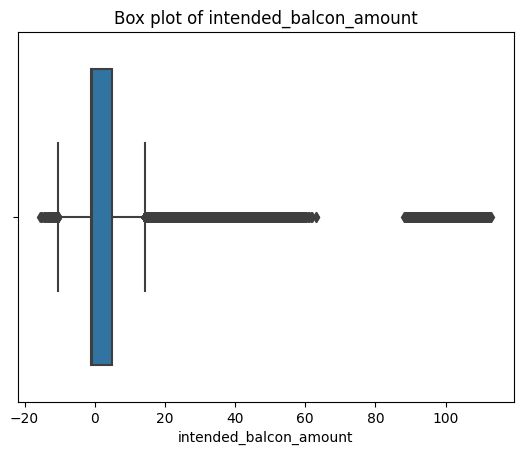

Processing column 9/20: velocity_6h


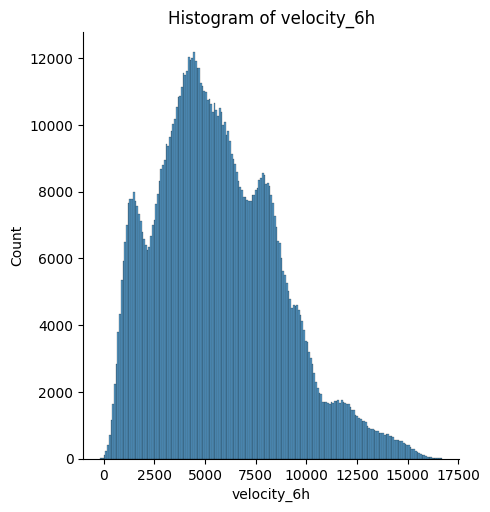

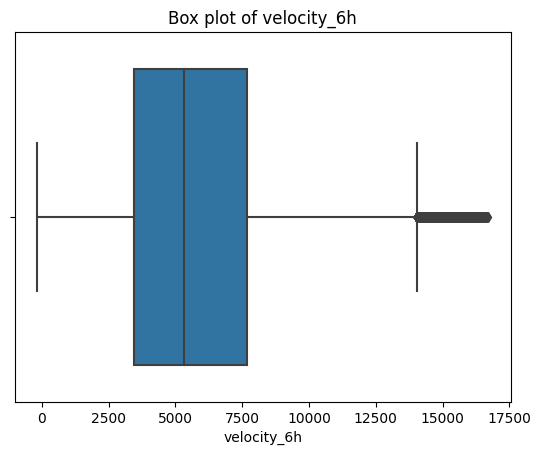

Processing column 10/20: velocity_24h


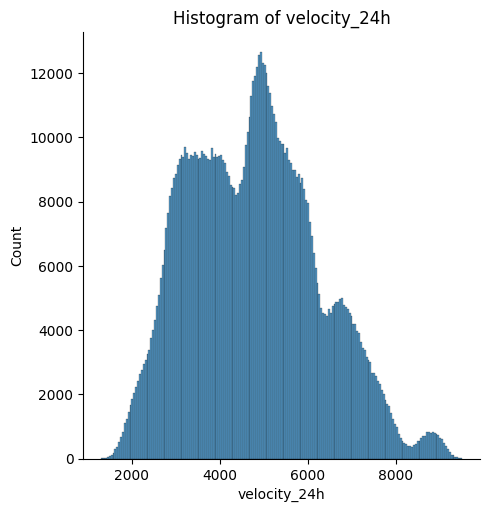

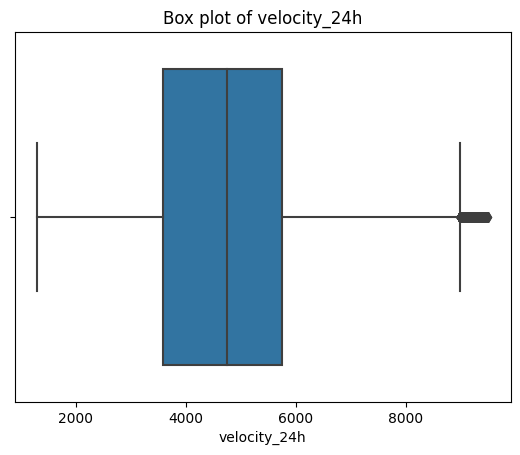

Processing column 11/20: velocity_4w


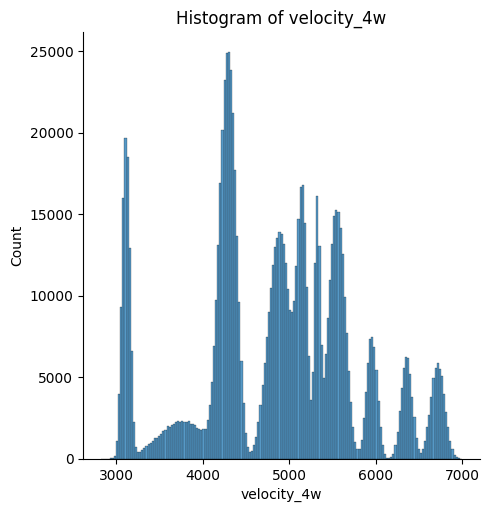

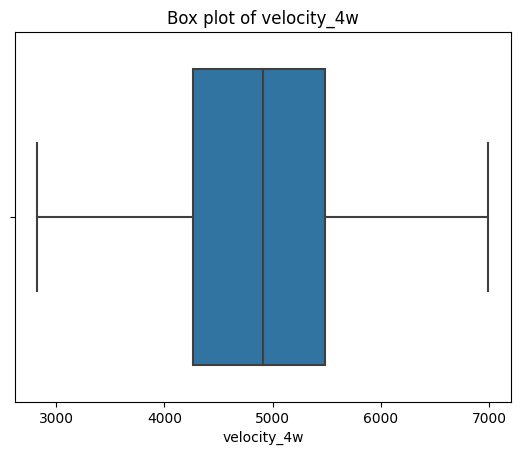

Processing column 12/20: credit_risk_score


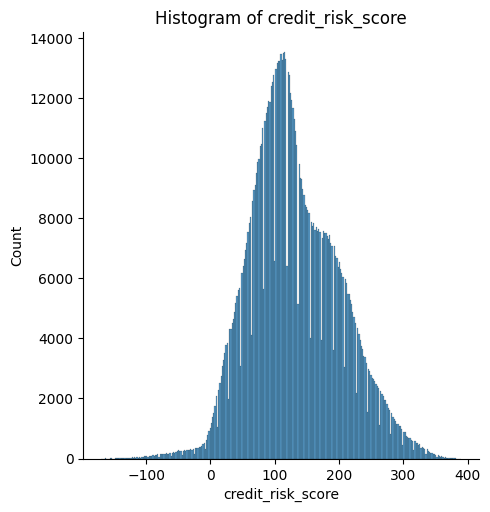

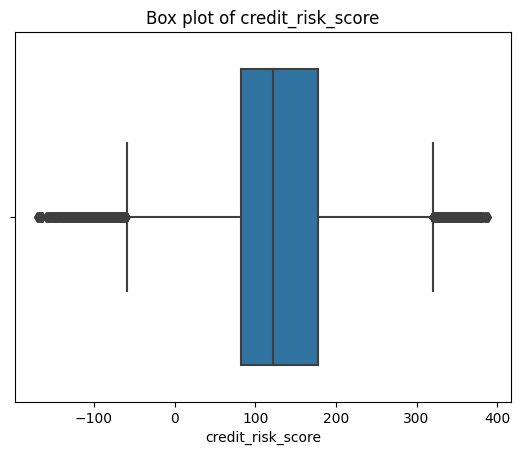

Processing column 13/20: phone_home_valid


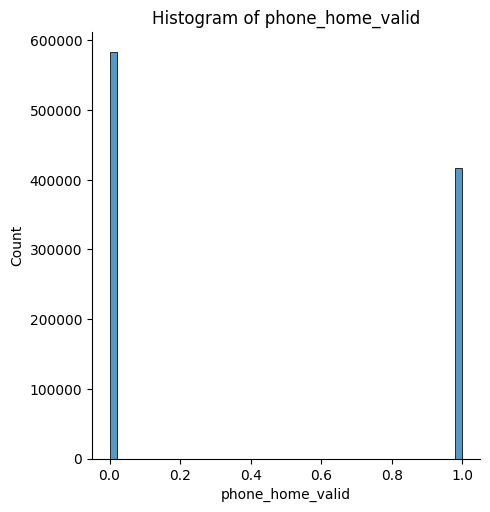

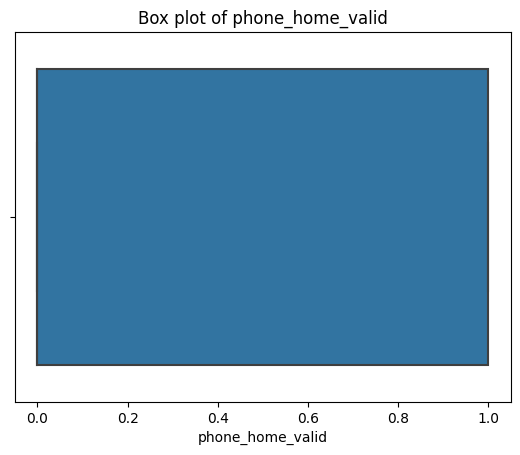

Processing column 14/20: phone_mobile_valid


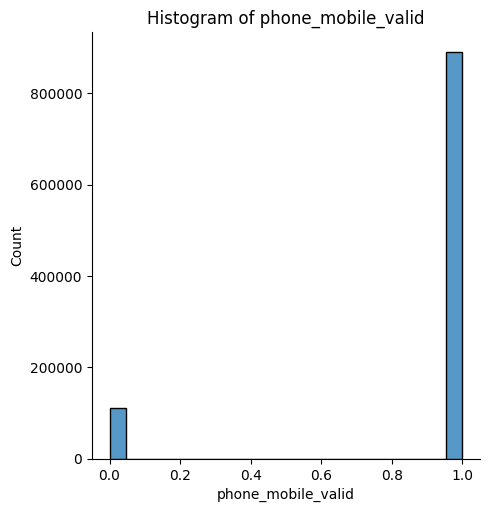

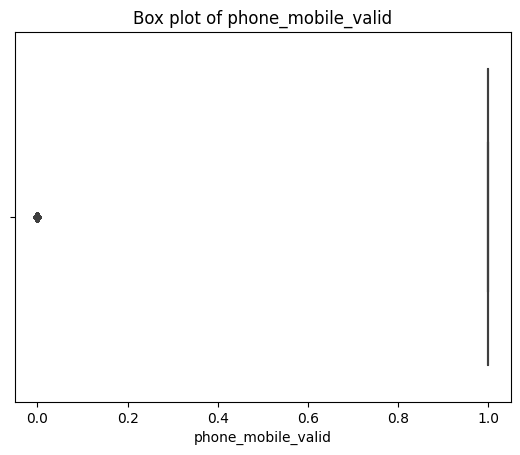

Processing column 15/20: has_other_cards


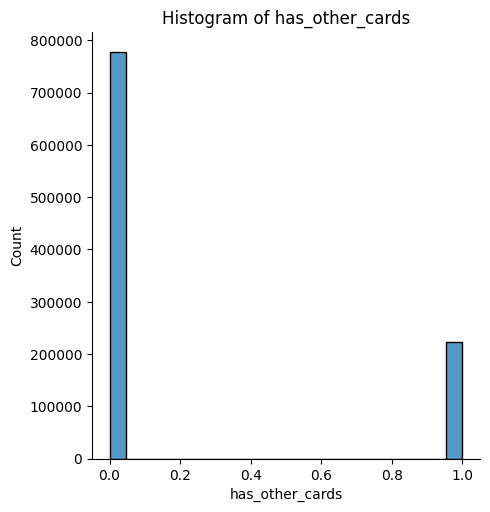

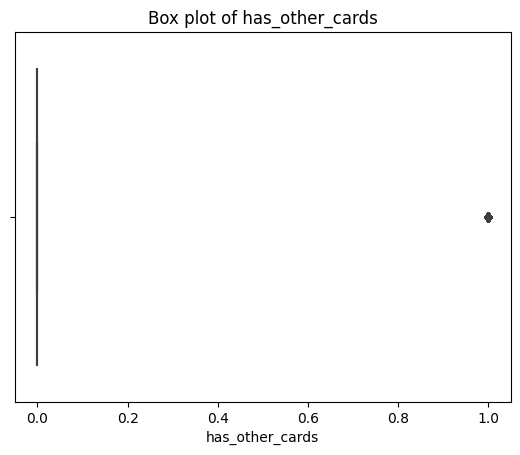

Processing column 16/20: proposed_credit_limit


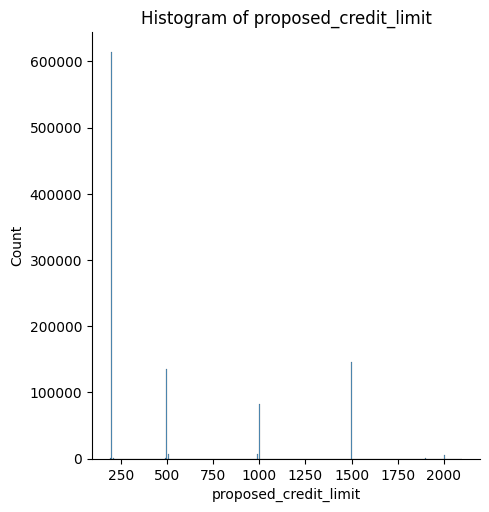

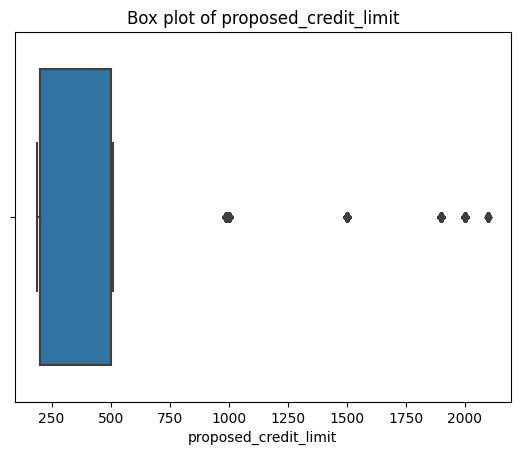

Processing column 17/20: foreign_request


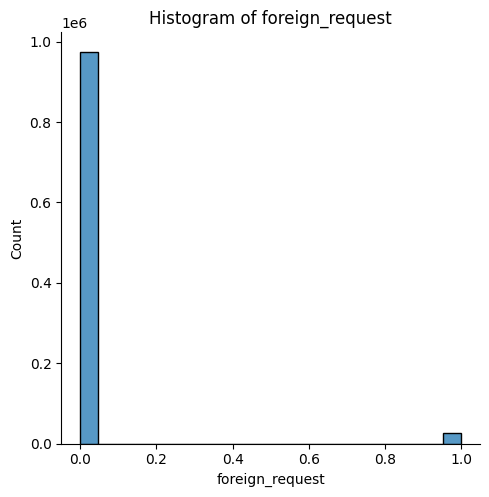

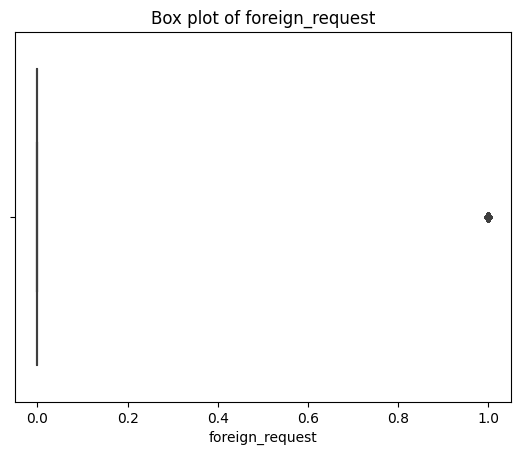

Processing column 18/20: session_length_in_minutes


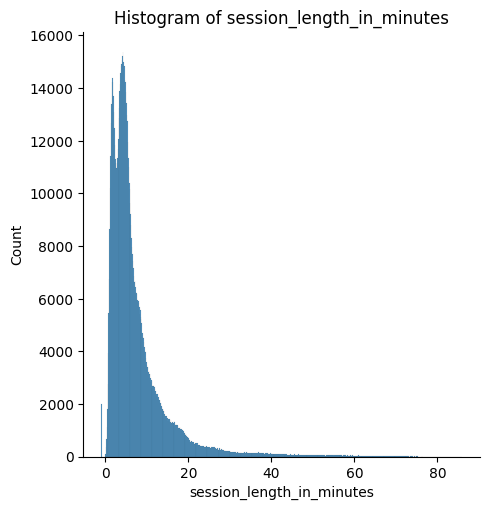

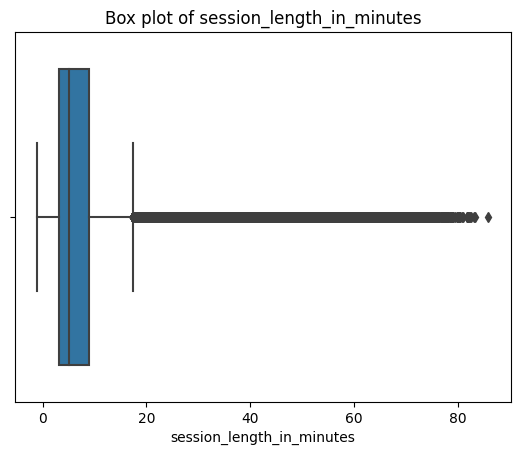

Processing column 19/20: keep_alive_session


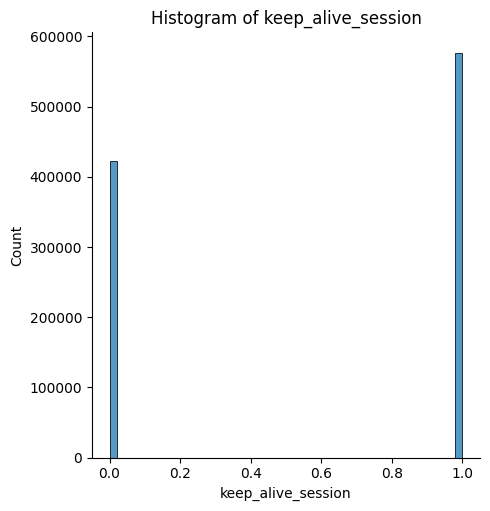

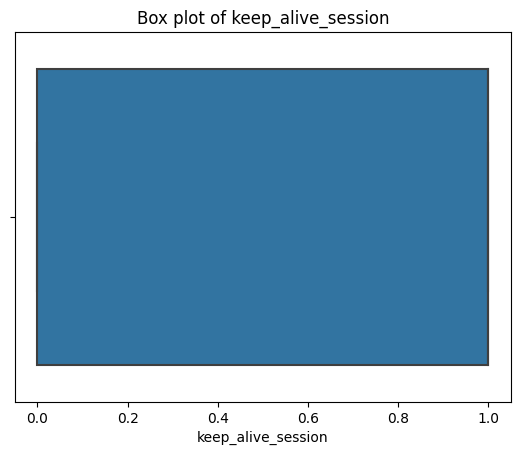

Processing column 20/20: device_distinct_emails_8w


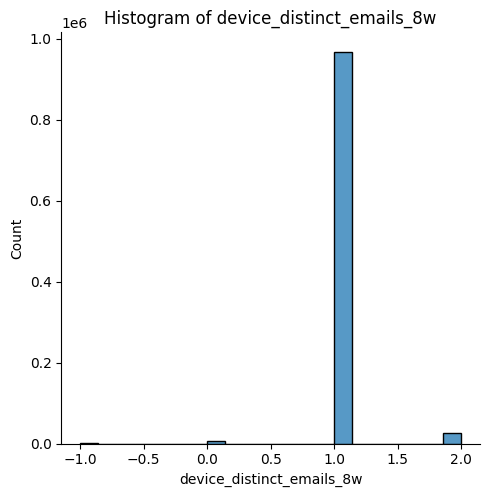

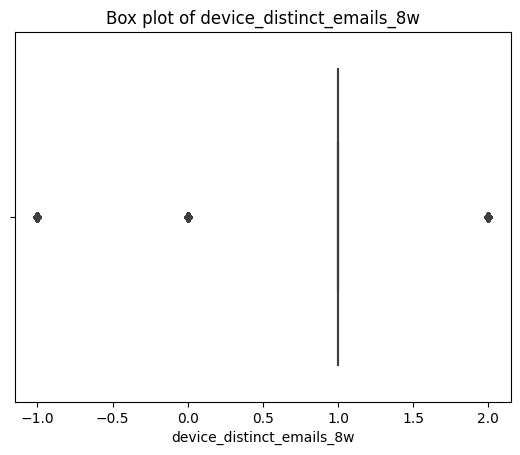

In [7]:
df_int_and_float = df.select_dtypes(include = ['int64', 'float64'])

for i, col in enumerate(df_int_and_float.columns):
    if (col == 'days_since_request'): 
        continue
    print(f"Processing column {i+1}/{len(df_int_and_float.columns)}: {col}")
    sns.displot(df_int_and_float[col], kde=False)
    plt.title(f"Histogram of {col}")
    plt.show()
    sns.boxplot(x=df_int_and_float[col])
    plt.title(f"Box plot of {col}")
    plt.show()

## Changing Data Types

In [8]:
# Changing data types for columns where values are 0 or 1 to boolean instead of int64
df['foreign_request']=df['foreign_request'].astype('bool')
df['fraud_bool']=df['fraud_bool'].astype('bool')
df['phone_home_valid']=df['phone_home_valid'].astype('bool')
df['phone_mobile_valid']=df['phone_mobile_valid'].astype('bool')
df['has_other_cards']=df['has_other_cards'].astype('bool')
df['keep_alive_session']=df['keep_alive_session'].astype('bool')


print(df.dtypes)

fraud_bool                         bool
income                          float64
name_email_similarity           float64
prev_address_months_count         int64
current_address_months_count      int64
customer_age                      int64
days_since_request              float64
intended_balcon_amount          float64
payment_type                     object
velocity_6h                     float64
velocity_24h                    float64
velocity_4w                     float64
employment_status                object
credit_risk_score                 int64
housing_status                   object
phone_home_valid                   bool
phone_mobile_valid                 bool
has_other_cards                    bool
proposed_credit_limit             int64
foreign_request                    bool
source                           object
session_length_in_minutes       float64
device_os                        object
keep_alive_session                 bool
device_distinct_emails_8w         int64


## Removing Outliers

In [9]:
# remove exceptional outliers 
df = df[df['customer_age'] < 70 ]
df = df[df['velocity_6h'] < 13000]

<Axes: xlabel='customer_age'>

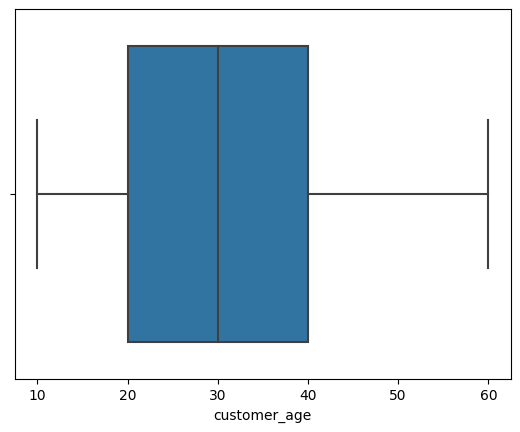

In [11]:
sns.boxplot(x=df['customer_age'])

<Axes: xlabel='velocity_6h'>

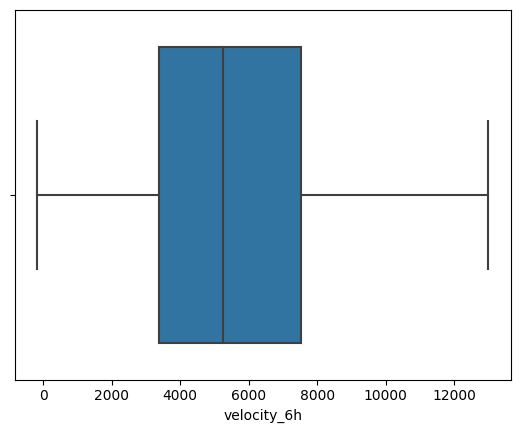

In [10]:
sns.boxplot(x=df['velocity_6h'])

## Checking for Duplicates 

In [12]:
# Check for duplicate rows across all columns
duplicates = df.duplicated(keep=False)

# Show only the duplicated rows
duplicate_rows = df[duplicates]

# Print the number of duplicate rows
print(f"Number of duplicate rows: {len(duplicate_rows)}")


Number of duplicate rows: 0


## Checking For Null Values 

In [13]:
print(df[df['prev_address_months_count'] == -1].shape[0])


691497


Since the number of rows which have  `prev_address_months_count` as -1 (prev_address_months_count is not available) make up more than 71% of the dataset, we decided to drop this column from our dataset since the column does not contain much important information.

In [14]:
df = df.drop(['prev_address_months_count'], axis=1) 

## Feature Engineering 

In [15]:
# Merging phone_home_valud and phone_mobile_valid with an OR statement to just obtain phone_valid
df['phone_valid'] = df['phone_home_valid'] | df['phone_mobile_valid']

In [16]:
# Droping the columns after merge
df = df.drop(['phone_home_valid', 'phone_mobile_valid'], axis=1)

In [17]:
df


,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,velocity_6h,velocity_24h,...,housing_status,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,phone_valid
0,True,0.9,0.166828,88,50,0.020925,-1.331345,AA,10650.765520,3134.319630,...,BA,False,500,False,INTERNET,3.888115,windows,False,1,True
1,True,0.9,0.296286,144,50,0.005418,-0.816224,AB,534.047319,2670.918292,...,BA,False,1500,False,INTERNET,31.798819,windows,False,1,False
2,True,0.9,0.044985,132,40,3.108549,-0.755728,AC,4048.534263,2893.621498,...,BA,False,200,False,INTERNET,4.728705,other,False,1,True
3,True,0.9,0.159511,22,50,0.019079,-1.205124,AB,3457.064063,4054.908412,...,BA,True,200,False,INTERNET,2.047904,linux,False,1,True
4,True,0.9,0.596414,218,50,0.004441,-0.773276,AB,5020.341679,2728.237159,...,BA,False,1500,False,INTERNET,3.775225,macintosh,True,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,False,0.6,0.192631,104,40,0.030592,-1.044454,AB,7905.711839,8341.468557,...,BC,False,200,False,INTERNET,8.511502,linux,True,1,True
999996,False,0.8,0.322989,9,50,1.628119,-1.409803,AC,5391.470463,4955.170808,...,BC,False,200,False,INTERNET,8.967865,windows,False,1,True
999997,False,0.8,0.879403,30,20,0.018563,34.692760,AA,8063.102636,5670.654316,...,BC,False,200,False,INTERNET,8.195531,other,False,1,True
999998,False,0.9,0.762112,189,20,0.015352,94.661055,AA,8092.641762,3982.582204,...,BA,False,500,False,INTERNET,4.336064,windows,True,1,True


# Load

## Generating Surrogate Keys

In [18]:
df['surrogate_keys'] = range(1,len(df)+1)
df

,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,velocity_6h,velocity_24h,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,phone_valid,surrogate_keys
0,True,0.9,0.166828,88,50,0.020925,-1.331345,AA,10650.765520,3134.319630,...,False,500,False,INTERNET,3.888115,windows,False,1,True,1
1,True,0.9,0.296286,144,50,0.005418,-0.816224,AB,534.047319,2670.918292,...,False,1500,False,INTERNET,31.798819,windows,False,1,False,2
2,True,0.9,0.044985,132,40,3.108549,-0.755728,AC,4048.534263,2893.621498,...,False,200,False,INTERNET,4.728705,other,False,1,True,3
3,True,0.9,0.159511,22,50,0.019079,-1.205124,AB,3457.064063,4054.908412,...,True,200,False,INTERNET,2.047904,linux,False,1,True,4
4,True,0.9,0.596414,218,50,0.004441,-0.773276,AB,5020.341679,2728.237159,...,False,1500,False,INTERNET,3.775225,macintosh,True,1,True,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,False,0.6,0.192631,104,40,0.030592,-1.044454,AB,7905.711839,8341.468557,...,False,200,False,INTERNET,8.511502,linux,True,1,True,973064
999996,False,0.8,0.322989,9,50,1.628119,-1.409803,AC,5391.470463,4955.170808,...,False,200,False,INTERNET,8.967865,windows,False,1,True,973065
999997,False,0.8,0.879403,30,20,0.018563,34.692760,AA,8063.102636,5670.654316,...,False,200,False,INTERNET,8.195531,other,False,1,True,973066
999998,False,0.9,0.762112,189,20,0.015352,94.661055,AA,8092.641762,3982.582204,...,False,500,False,INTERNET,4.336064,windows,True,1,True,973067


In [19]:
df_stagged = df.reindex(columns=['surrogate_keys'] + list([c for c in df.columns if c!= 'surrogate_keys']))
df_stagged

,surrogate_keys,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,velocity_6h,...,housing_status,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,phone_valid
0,1,True,0.9,0.166828,88,50,0.020925,-1.331345,AA,10650.765520,...,BA,False,500,False,INTERNET,3.888115,windows,False,1,True
1,2,True,0.9,0.296286,144,50,0.005418,-0.816224,AB,534.047319,...,BA,False,1500,False,INTERNET,31.798819,windows,False,1,False
2,3,True,0.9,0.044985,132,40,3.108549,-0.755728,AC,4048.534263,...,BA,False,200,False,INTERNET,4.728705,other,False,1,True
3,4,True,0.9,0.159511,22,50,0.019079,-1.205124,AB,3457.064063,...,BA,True,200,False,INTERNET,2.047904,linux,False,1,True
4,5,True,0.9,0.596414,218,50,0.004441,-0.773276,AB,5020.341679,...,BA,False,1500,False,INTERNET,3.775225,macintosh,True,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,973064,False,0.6,0.192631,104,40,0.030592,-1.044454,AB,7905.711839,...,BC,False,200,False,INTERNET,8.511502,linux,True,1,True
999996,973065,False,0.8,0.322989,9,50,1.628119,-1.409803,AC,5391.470463,...,BC,False,200,False,INTERNET,8.967865,windows,False,1,True
999997,973066,False,0.8,0.879403,30,20,0.018563,34.692760,AA,8063.102636,...,BC,False,200,False,INTERNET,8.195531,other,False,1,True
999998,973067,False,0.9,0.762112,189,20,0.015352,94.661055,AA,8092.641762,...,BA,False,500,False,INTERNET,4.336064,windows,True,1,True


## Loading Final Dataset 

In [63]:
df_stagged.to_csv('Stagged_data.csv')
# Saving the transformed dataset 

In [67]:
df = pd.read_csv('Stagged_data.csv')

# Create transaction table
df_transaction = df[['surrogate_keys','source', 'payment_type', 'days_since_request', 'intended_balcon_amount', 'foreign_request']]
df_transaction.to_csv('transaction_dimension.csv', index=False)

# Create Applicant table
df_applicant = df[['surrogate_keys','income', 'current_address_months_count', 'customer_age', 'employment_status', 'credit_risk_score', 'housing_status', 'phone_valid', 'has_other_cards', 'proposed_credit_limit']]
df_applicant.to_csv('applicant_dimension.csv', index=False)

# Create Session table
df_session = df[['surrogate_keys','session_length_in_minutes', 'keep_alive_session']]
df_session.to_csv('session_dimension.csv', index=False)

# Create Device table
df_device = df[['surrogate_keys','device_os', 'device_distinct_emails_8w']]
df_device.to_csv('device_dimension.csv', index=False)

df_fact_table = df[['surrogate_keys','fraud_bool','name_email_similarity','velocity_4w','velocity_24h','velocity_6h']]
df_fact_table.to_csv('temp_fact_table.csv', index=False)

In [68]:
def load_csv_into_table(file_name, table_name):
    # Create a connection to the PostgreSQL database using provided connection information
    engine = create_engine('postgresql://<USERNAME>:<PASSWORD>@localhost/banking_transactions')

    # Define chunk size
    chunksize = 10000

    # Define dictionary to map table names to primary key column names
    primary_keys = {
        'transaction_dimension': 'transaction_id',
        'applicant_dimension': 'applicant_id',
        'session_dimension': 'session_id',
        'device_dimension': 'device_id'
    }

    # Initialize maximum primary key value
    max_primary_key_value = 0

    # Load and process CSV file in chunks
    for chunk in pd.read_csv(file_name, chunksize=chunksize):
        # Add primary key column to DataFrame chunk
        if table_name in primary_keys:
            chunk[primary_keys[table_name]] = range(max_primary_key_value + 1, max_primary_key_value + len(chunk) + 1)
            max_primary_key_value += len(chunk)

        # Use bulk inserts to insert data from DataFrame chunk into database table
        chunk.to_sql(table_name, engine, index=False, method='multi', if_exists='append')

# Define list of CSV files and corresponding table names
files_and_tables = [
    ('transaction_dimension.csv', 'transaction_dimension'),
    ('applicant_dimension.csv', 'applicant_dimension'),
    ('session_dimension.csv', 'session_dimension'),
    ('device_dimension.csv', 'device_dimension'),
    ('temp_fact_table.csv','temp_fact_table')
]

# Use concurrent.futures to run data loading code in parallel for each CSV file
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(load_csv_into_table, file_name, table_name) for file_name, table_name in files_and_tables]

In [69]:

engine2 = create_engine('postgresql://<USERNAME>:<PASSWORD>@localhost/banking_transactions')
with engine2.connect() as conn:
    query1="ALTER TABLE transaction_dimension ADD CONSTRAINT transaction_id_unique UNIQUE (transaction_id);"
    query2= "ALTER TABLE session_dimension ADD CONSTRAINT session_id_unique UNIQUE (session_id);"
    query3= "ALTER TABLE applicant_dimension ADD CONSTRAINT applicant_id_unique UNIQUE (applicant_id);"
    query4="ALTER TABLE device_dimension ADD CONSTRAINT device_id_unique UNIQUE (device_id);"
    conn.execute(text(query1))
    conn.execute(text(query2))
    conn.execute(text(query3))
    conn.execute(text(query4))
    conn.commit()

  

In [70]:
engine = create_engine('postgresql://<USERNAME>:<PASSWORD>@localhost/banking_transactions')

with engine.connect() as conn:
    query ="ALTER TABLE temp_fact_table ADD COLUMN transaction_id INTEGER REFERENCES transaction_dimension(transaction_id),ADD COLUMN applicant_id INTEGER REFERENCES applicant_dimension(applicant_id),ADD COLUMN device_id INTEGER REFERENCES device_dimension(device_id), ADD COLUMN session_id INTEGER REFERENCES session_dimension(session_id);"
    conn.execute(text(query))
conn.commit()

In [71]:

# create a connection to a PostgreSQL database
conn = psycopg2.connect(
    host="localhost",
    database="banking_transactions",
    user="<USERNAME>",
    password="<PASSWORD>"
)

# create a cursor object to execute SQL queries
cursor = conn.cursor()

# execute the SQL query to create the fact_table
cursor.execute('''CREATE TABLE fact_table (
                    surrogate_keys INT,
                    fraud_bool BOOL,
                    name_email_similarity FLOAT,
                    velocity_4w FLOAT,
                    velocity_24h FLOAT,
                    velocity_6h FLOAT,
                    transaction_id INT,
                    session_id INT,
                    applicant_id INT,
                    device_id INT,
                    FOREIGN KEY (transaction_id) REFERENCES transaction_dimension (transaction_id),
                    FOREIGN KEY (session_id) REFERENCES session_dimension (session_id),
                    FOREIGN KEY (applicant_id) REFERENCES applicant_dimension (applicant_id),
                    FOREIGN KEY (device_id) REFERENCES device_dimension (device_id)
                    );''')

# execute the SQL query to insert data into fact_table
cursor.execute('''INSERT INTO fact_table (surrogate_keys, fraud_bool, name_email_similarity, velocity_4w, velocity_24h, velocity_6h, transaction_id)
                  SELECT tft.surrogate_keys, tft.fraud_bool, tft.name_email_similarity, tft.velocity_4w, tft.velocity_24h, tft.velocity_6h, td.transaction_id
                  FROM temp_fact_table tft
                  JOIN transaction_dimension td ON tft.surrogate_keys = td.surrogate_keys;''')

# execute the SQL query to update the session_id column in fact_table
cursor.execute('''UPDATE fact_table ft
                  SET session_id = sd.session_id
                  FROM session_dimension sd
                  WHERE ft.surrogate_keys = sd.surrogate_keys;''')

# execute the SQL query to update the applicant_id column in fact_table
cursor.execute('''UPDATE fact_table ft
                  SET applicant_id = ad.applicant_id
                  FROM applicant_dimension ad
                  WHERE ft.surrogate_keys = ad.surrogate_keys;''')

# execute the SQL query to update the device_id column in fact_table
cursor.execute('''UPDATE fact_table ft
                  SET device_id = dd.device_id
                  FROM device_dimension dd
                  WHERE ft.surrogate_keys = dd.surrogate_keys;''')

# commit the changes to the database
conn.commit()

# close the cursor and connection
cursor.close()
conn.close()


In [ ]:
# Drop temp_fact_table

# create a connection to a PostgreSQL database
conn = psycopg2.connect(
    host="localhost",
    database="banking_transactions",
    user="<USERNAME>",
    password="<PASSWORD>"
)
cursor = conn.cursor()
cursor.execute('''DROP TABLE temp_fact_table;''')
conn.commit()
cursor.close()
conn.close()